## Binary Image Classification v1.0 - Cat v/s Dog

### Author : Abhishek Dey "<ai.abhishekdey@gmail.com>"

### Import Libraries and Packages

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model

### Set GPU Flags

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Separate out dogs and cats in different folders

In [4]:
train_val_data_dir="dogs-vs-cats/train/"

train_val_dogs="dogs-vs-cats/train_val_images/dogs"
train_val_cats="dogs-vs-cats/train_val_images/cats"

if not os.path.exists(train_val_dogs):
    os.makedirs(train_val_dogs)
    
if not os.path.exists(train_val_cats):
    os.makedirs(train_val_cats)
    
source=train_val_data_dir
destination1=train_val_dogs
destination2=train_val_cats

for filename in os.listdir(source):
    if filename.startswith("dog"):
        shutil.copy(os.path.join(source, filename), destination1)
        
for filename in os.listdir(source):
    if filename.startswith("cat"):
        shutil.copy(os.path.join(source, filename), destination2)

### Get the counts of cats and dogs in train-val set

In [5]:
cat_count = 0
dog_count = 0 


for path in os.scandir(train_val_dogs):
    if path.is_file():
        dog_count += 1
print('train-val dogs count:', dog_count)

for path in os.scandir(train_val_cats):
    if path.is_file():
        cat_count += 1
print('train-val cats count:', cat_count)

train-val dogs count: 12500
train-val cats count: 12500


### Set Hyperparameters

In [6]:
ep=50
bs=8
img_size=64
lr=0.00001
loss_fn='binary_crossentropy'

### Custom CNN Model

In [7]:
input_shape = (img_size, img_size, 3)

model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

### Data Generation and train-val split in the ratio of 80:20

In [9]:
data_path = "dogs-vs-cats/train_val_images/"

data_gen = ImageDataGenerator(rescale=1./255,  validation_split=0.2)

train_data = data_gen.flow_from_directory(directory=data_path,target_size=(img_size,img_size), batch_size=bs, subset='training', seed=42, color_mode='rgb', class_mode='binary') 

val_data = data_gen.flow_from_directory(directory=data_path,target_size=(img_size,img_size), batch_size=bs, subset='validation', seed=42, color_mode='rgb', class_mode='binary') 

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Model Compile

In [10]:
opt = Adam(learning_rate=lr)

model.compile(loss=loss_fn,optimizer=opt,metrics=['accuracy'])

### Checkpoint directory

In [11]:
checkpoint_dir="custom_cnn_model/"
model_version="1.0"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Call backs

In [12]:
checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir,'binary_model_v' + str(model_version) + '.h5'), 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
csv_logger = CSVLogger(checkpoint_dir + '/' + 'log_model_v' + str(model_version) + '.csv')

early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=1,
        mode='auto')

### Model Fit

In [14]:
steps_train=train_data.n/ bs

steps_val = val_data.n / bs



history = model.fit(train_data, epochs=ep, steps_per_epoch=steps_train, validation_data=val_data, validation_steps=steps_val, callbacks= [checkpoint, csv_logger, early_stop])

Epoch 1/50
2500/2500 [==============================] - 125s 36ms/step - loss: 0.6784 - accuracy: 0.5546 - val_loss: 0.6220 - val_accuracy: 0.6596

Epoch 00001: val_loss improved from inf to 0.62203, saving model to custom_cnn_model/binary_model_v1.0.h5
Epoch 2/50
2500/2500 [==============================] - 89s 36ms/step - loss: 0.6163 - accuracy: 0.6639 - val_loss: 0.5762 - val_accuracy: 0.6960

Epoch 00002: val_loss improved from 0.62203 to 0.57620, saving model to custom_cnn_model/binary_model_v1.0.h5
Epoch 3/50
2500/2500 [==============================] - 89s 36ms/step - loss: 0.5712 - accuracy: 0.7012 - val_loss: 0.6169 - val_accuracy: 0.6532

Epoch 00003: val_loss did not improve from 0.57620
Epoch 4/50
2500/2500 [==============================] - 90s 36ms/step - loss: 0.5280 - accuracy: 0.7382 - val_loss: 0.4980 - val_accuracy: 0.7590

Epoch 00004: val_loss improved from 0.57620 to 0.49800, saving model to custom_cnn_model/binary_model_v1.0.h5
Epoch 5/50
2500/2500 [============

### Loss Plots

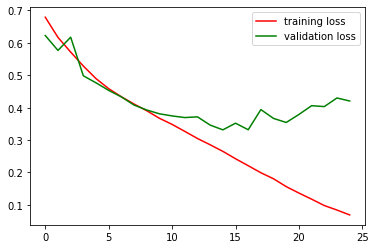

In [15]:
df_plot=pd.read_csv(os.path.join(checkpoint_dir, 'log_model_v' + str(model_version) + '.csv'))
training_loss=df_plot['loss']
validation_loss=df_plot['val_loss']
training_acc=df_plot['accuracy']
validation_acc=df_plot['val_accuracy']

plt.plot(training_loss,color='r')
plt.plot(validation_loss,color='g')
plt.legend(["training loss", "validation loss"], loc ="upper right")

## Accuracy Plots

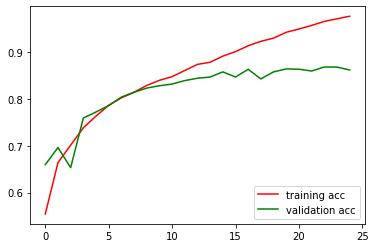

In [16]:
plt.plot(training_acc,color='r')
plt.plot(validation_acc,color='g')
plt.legend(["training acc", "validation acc"], loc ="lower right")

### Evaluation on Validation set

In [17]:
model_path = os.path.join(checkpoint_dir, 'binary_model_v' + str(model_version) + '.h5')
model = load_model(model_path)
_,val_accuracy = model.evaluate(val_data, steps=steps_val)

625/625 [==============================] - 8s 13ms/step - loss: 0.3315 - accuracy: 0.8574


### Prediction on Test set and strore the prediction results in csv file

In [75]:
test_set_dir="dogs-vs-cats/test1/"
out_csv = os.path.join(checkpoint_dir,"test_set_pred_" + str(model_version) + ".csv")

f=open(out_csv,'w')
f.write("filepath,prediction_label,prediction_class"+"\n")

43

In [76]:

for img in sorted(os.listdir(test_set_dir)):
    
    img_name = os.path.join(test_set_dir, img)
    
    img = load_img(img_name, target_size=(img_size, img_size))
    
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    
    if pred[0][0] > 0.5:
        
        result=1
        pred_class='dog'
        
    else:
        
        result=0
        pred_class='cat'
    
    #print(img_name,result,pred_class)
    f.write(str(img_name) + "," + str(result) + "," + str(pred_class) + "\n")

f.close()

### Convert Keras model to ONNX

In [45]:
!pip install tf2onnx

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [47]:
import tensorflow as tf
import tf2onnx
import onnx

In [49]:
keras_model_path=os.path.join(checkpoint_dir,'binary_model_v' + str(model_version) + '.h5')

In [50]:
keras_model_path

'custom_cnn_model/binary_model_v1.0.h5'

In [51]:
onnx_model_path=os.path.join(checkpoint_dir,'binary_model_v' + str(model_version) + '.onnx')

In [52]:
onnx_model_path

'custom_cnn_model/binary_model_v1.0.onnx'

In [54]:
keras_model = load_model(keras_model_path)
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [59]:
spec = (tf.TensorSpec((None, 64, 64, 3), tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(keras_model, input_signature=spec, opset=13, output_path=onnx_model_path)

onnx.save(onnx_model, onnx_model_path)

### Inference using Onnx model on test set

In [58]:
! pip install onnxruntime-gpu

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [64]:
import onnxruntime as ort

sess = ort.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"])

input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

print("input_name : ",input_name)
print("output_name : ",input_name)

input_name :  input
output_name :  input


In [77]:
test_set_dir="dogs-vs-cats/test1/"
out_csv = os.path.join(checkpoint_dir,"test_set_pred_onnx" + str(model_version) + ".csv")

f=open(out_csv,'w')
f.write("filepath,prediction_label,prediction_class"+"\n")

43

In [78]:
for img in sorted(os.listdir(test_set_dir)):
    
    img_name = os.path.join(test_set_dir, img)
    
    img = load_img(img_name, target_size=(img_size, img_size))
    
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    
    
    onnx_pred = sess.run([output_name], {input_name: img})
    
    if onnx_pred[0][0] > 0.5:
        
        result=1
        pred_class='dog'
        
    else:
        
        result=0
        pred_class='cat'
    
    #print(img_name,result,pred_class)
    f.write(str(img_name) + "," + str(result) + "," + str(pred_class) + "\n")

f.close()

### References:

* https://onnxruntime.ai/docs/tutorials/tf-get-started.html

* https://github.com/onnx/tensorflow-onnx/blob/82812543c22e1318ca1ffa4e5431830c17d16d29/tutorials/keras-resnet50.ipynb

* https://www.youtube.com/watch?v=lRBsmnBE9ZA

* https://github.com/onnx/tensorflow-onnx/blob/main/tutorials/efficientnet-edge.ipynb